In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import spearmanr

import os
# os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources"
# import pertpy as pt
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co

import warnings
warnings.filterwarnings("ignore")

## Preprocessing
### Read data

In [2]:
data_path = "../../data/MOBA_scRNAseq/outs_S3"
data_all = sc.read_10x_h5(data_path + "/filtered_feature_bc_matrix.h5")
data_all

AnnData object with n_obs × n_vars = 1652 × 21982
    var: 'gene_ids', 'feature_types', 'genome'

### Aggregate probes through max-pooling

In [3]:
data_maxpool = up.prep_probe_BacSC_data(data_all, agg_fn=np.max)
sc.pp.calculate_qc_metrics(data_maxpool, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_maxpool

Aggregating feature 100/5572
Aggregating feature 200/5572
Aggregating feature 300/5572
Aggregating feature 400/5572
Aggregating feature 500/5572
Aggregating feature 600/5572
Aggregating feature 700/5572
Aggregating feature 800/5572
Aggregating feature 900/5572
Aggregating feature 1000/5572
Aggregating feature 1100/5572
Aggregating feature 1200/5572
Aggregating feature 1300/5572
Aggregating feature 1400/5572
Aggregating feature 1500/5572
Aggregating feature 1600/5572
Aggregating feature 1700/5572
Aggregating feature 1800/5572
Aggregating feature 1900/5572
Aggregating feature 2000/5572
Aggregating feature 2100/5572
Aggregating feature 2200/5572
Aggregating feature 2300/5572
Aggregating feature 2400/5572
Aggregating feature 2500/5572
Aggregating feature 2600/5572
Aggregating feature 2700/5572
Aggregating feature 2800/5572
Aggregating feature 2900/5572
Aggregating feature 3000/5572
Aggregating feature 3100/5572
Aggregating feature 3200/5572
Aggregating feature 3300/5572
Aggregating feature

AnnData object with n_obs × n_vars = 1652 × 5572
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [4]:
print(f"Zero inflation of probe-wise data: {((np.prod(data_all.X.shape) - data_all.X.getnnz()) / np.prod(data_all.X.shape)).round(3)}")
print(f"Zero inflation of aggregated data: {((np.prod(data_maxpool.X.shape) - data_maxpool.X.getnnz()) / np.prod(data_maxpool.X.shape)).round(3)}")


Zero inflation of probe-wise data: 0.936
Zero inflation of aggregated data: 0.831


## Attach transcription units

In [5]:
tu = pd.read_csv("../../data/MOBA_scRNAseq/PAO1 gene ID and TU.csv")
tu

,PAO1_ID,TU_ID,Regulation - transcription units of gene
0,PA0001,1,gyrB // recF // dnaN // dnaA
1,PA0002,1,gyrB // recF // dnaN // dnaA
2,PA0003,1,gyrB // recF // dnaN // dnaA
3,PA0004,1,gyrB // recF // dnaN // dnaA
4,PA0005,2,PA0006 // lptA
...,...,...,...
5692,PA5566,3750,PA5566
5693,PA5567,3751,PA5567
5694,PA5568,3752,PA5568
5695,PA5569,3753,rpmH // rnpA


In [6]:
data_maxpool.var = pd.merge(data_maxpool.var, tu, left_index=True, right_on="PAO1_ID")
data_maxpool.var.index = data_maxpool.var["PAO1_ID"]
data_maxpool.var

,feature_types,genome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,PAO1_ID,TU_ID,Regulation - transcription units of gene
PAO1_ID,,,,,,,,,,,
PA0001,Gene Expression,PA01,842,1.230630,0.802284,49.031477,2033.0,7.617760,PA0001,1,gyrB // recF // dnaN // dnaA
PA0002,Gene Expression,PA01,645,0.904964,0.644463,60.956416,1495.0,7.310550,PA0002,1,gyrB // recF // dnaN // dnaA
PA0003,Gene Expression,PA01,998,1.796005,1.028192,39.588378,2967.0,7.995644,PA0003,1,gyrB // recF // dnaN // dnaA
PA0004,Gene Expression,PA01,563,0.702179,0.531909,65.920097,1160.0,7.057037,PA0004,1,gyrB // recF // dnaN // dnaA
PA0005,Gene Expression,PA01,254,0.252421,0.225079,84.624697,417.0,6.035481,PA0005,2,PA0006 // lptA
...,...,...,...,...,...,...,...,...,...,...,...
PA5566,Gene Expression,PA01,26,0.019370,0.019185,98.426150,32.0,3.496508,PA5566,3750,PA5566
PA5567,Gene Expression,PA01,254,0.266949,0.236612,84.624697,441.0,6.091310,PA5567,3751,PA5567
PA5568,Gene Expression,PA01,846,1.214286,0.794930,48.789346,2006.0,7.604396,PA5568,3752,PA5568


### Filter cells

--> filter based on mean absolute standard deviation

In [7]:
data_gene = ut.filter_outliers(data_maxpool, nmads=5, min_cells=2)
print(data_maxpool.obs.outlier.value_counts())
print(f"Total number of cells: {data_maxpool.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

outlier
False    1544
True      108
Name: count, dtype: int64
Total number of cells: 1652
Number of cells after filtering: 1544


AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'PAO1_ID', 'TU_ID', 'Regulation - transcription units of gene', 'n_cells'

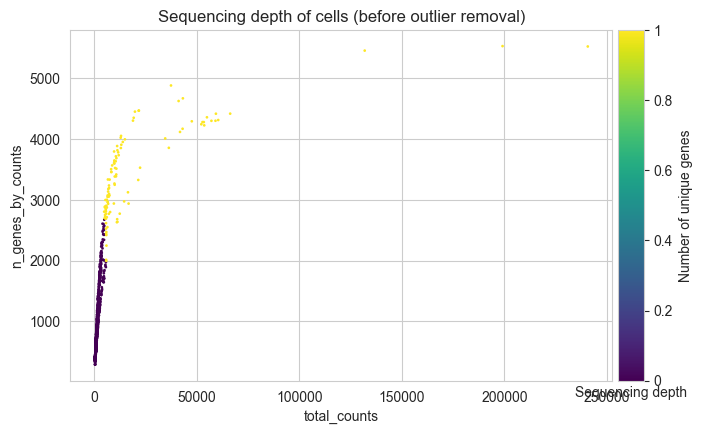

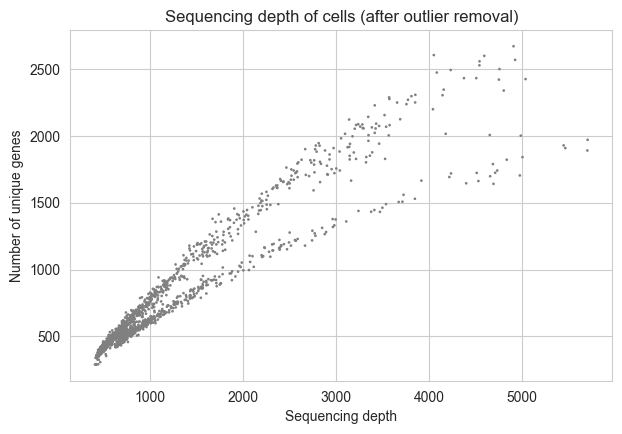

In [8]:
sc.pl.scatter(data_maxpool, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="viridis", title="Sequencing depth of cells (before outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15)
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

## GCF processing

In [9]:
data_gene.var_names

Index(['PA0001', 'PA0002', 'PA0003', 'PA0004', 'PA0005', 'PA0006', 'PA0007',
       'PA0008', 'PA0009', 'PA0010',
       ...
       'PA5561', 'PA5562', 'PA5563', 'PA5564', 'PA5565', 'PA5566', 'PA5567',
       'PA5568', 'PA5569', 'PA5570'],
      dtype='object', name='PAO1_ID', length=5553)

In [10]:
gff = pd.read_csv("../../data/MOBA_scRNAseq/GCF_000006765.1/genomic.gff",
                 sep="\t", comment='#', names=['chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'])
chrom_length = gff.loc[0, 'end']

gff['name'] = gff['attribute'].str.replace("^.*;Name=", "", regex=True).str.replace(";.*$", "", regex=True)
gff['locus_tag'] = gff['attribute'].str.replace("^.*;locus_tag=", "", regex=True).str.replace(";.*$", "", regex=True)

gff = gff[gff['feature'] == 'gene'] # Filter for only genes
gff = gff[['chrom', 'start', 'end', 'strand', 'name', 'locus_tag']]
gff.reset_index(inplace=True)

# Set the starting position of each gene (depending on strand)
def set_coord(x):
    if x['strand'] == '+':
        return x['start']
    elif x['strand'] == '-':
        return x['end']
    else:
        raise ValueError('Strand should not be ' + x['strand'])

gff['coord'] = gff.apply(set_coord, axis=1)
gff.index = gff['locus_tag']

# Start of the replication origin - Taken directly from the genbank annotation
origin_start = 6264259 - 6264403
origin_end = 448
origin_midpoint = (origin_start + origin_end) / 2 # The +1 gives the origin an integer value
print(origin_midpoint)

# Reset the start coordinate so that the origin is at zero, then sort the GFF by this value
gff = gff.loc[pd.Series(data_gene.var_names),:]
gff['coord'] = (gff['coord'] - origin_midpoint) % chrom_length
gff = gff.sort_values('coord')

# Filter out extrachromosomal genes (important for genomes with extrachromosomal elements):
gff = gff.loc[gff['chrom'] == 'NC_002516.2']

gff.head()

152.0


,index,chrom,start,end,strand,name,locus_tag,coord
locus_tag,,,,,,,,
PA0001,1,NC_002516.2,483,2027,+,dnaA,PA0001,331.0
PA0002,3,NC_002516.2,2056,3159,+,dnaN,PA0002,1904.0
PA0003,5,NC_002516.2,3169,4278,+,recF,PA0003,3017.0
PA0004,7,NC_002516.2,4275,6695,+,gyrB,PA0004,4123.0
PA0005,9,NC_002516.2,7018,7791,-,lptA,PA0005,7639.0


## Correlations on raw counts

In [11]:
data_gene.layers["counts"] = data_gene.X.copy()

In [12]:
cor_raw = spearmanr(data_gene.X.toarray())
cor_raw = pd.DataFrame(cor_raw.statistic, index=data_gene.var_names, columns=data_gene.var_names)

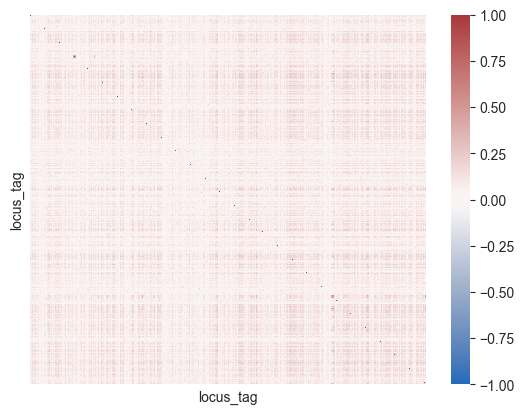

In [13]:
sns.heatmap(cor_raw.loc[gff.index, gff.index],
            cmap='vlag', vmin=-1, vmax=1, center=0,
            xticklabels=False, yticklabels=False)
plt.show()

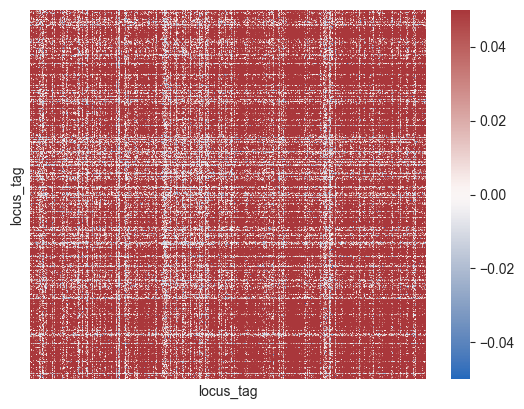

In [14]:
sns.heatmap(cor_raw.loc[gff.index, gff.index],
            cmap='vlag', vmin=-0.05, vmax=0.05, center=0,
            xticklabels=False, yticklabels=False)
plt.show()

## With normalized data - relative abundance and log2 scaling (as Poutain et al.)

In [15]:
data_gene.X = data_gene.layers["counts"].copy()

In [16]:
data_gene.X = data_gene.X.toarray() / data_gene.X.toarray().sum(axis=1, keepdims=True)
data_gene.X = sps.csr_matrix(np.log2(data_gene.X + 1))
data_gene.layers["norm_counts"] = data_gene.X.copy()

In [17]:
cor_norm = spearmanr(data_gene.X.toarray())
cor_norm = pd.DataFrame(cor_norm.statistic, index=data_gene.var_names, columns=data_gene.var_names)

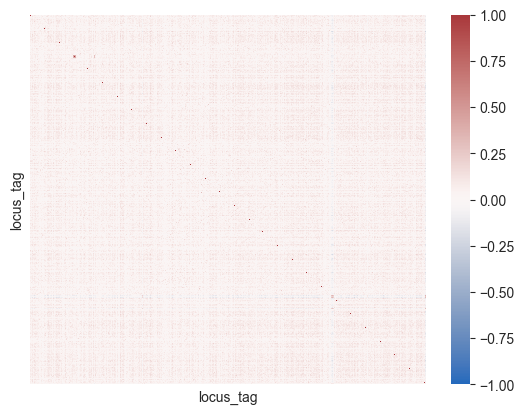

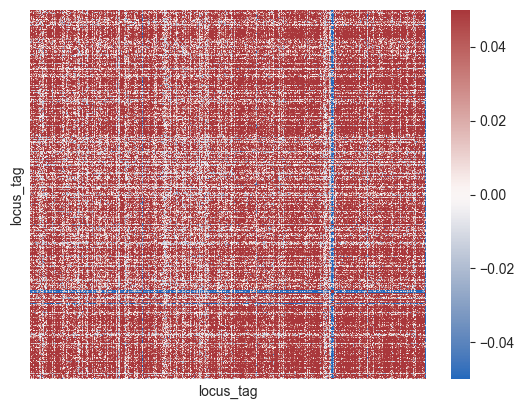

In [18]:
sns.heatmap(cor_norm.loc[gff.index, gff.index],
            cmap='vlag', vmin=-1, vmax=1, center=0,
            xticklabels=False, yticklabels=False)
plt.show()
sns.heatmap(cor_norm.loc[gff.index, gff.index],
            cmap='vlag', vmin=-0.05, vmax=0.05, center=0,
            xticklabels=False, yticklabels=False)
plt.show()

## With normalized data - our method

In [19]:
data_gene.X = data_gene.layers["counts"].copy()
nb.estimate_overdisp_nb(data_gene, layer="counts")

In [20]:
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)
data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))
data_gene.layers["vst_counts"] = data_gene.X.copy()

In [21]:
cor_vst = spearmanr(data_gene.X.toarray())
cor_vst = pd.DataFrame(cor_vst.statistic, index=data_gene.var_names, columns=data_gene.var_names)

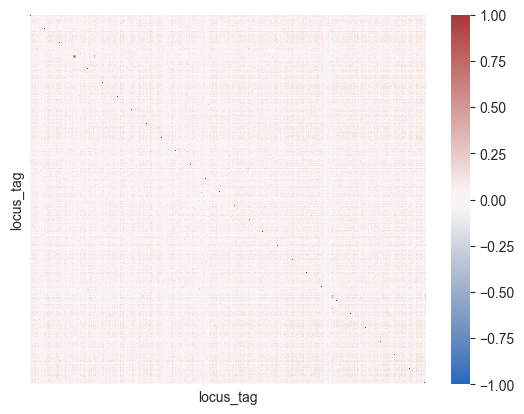

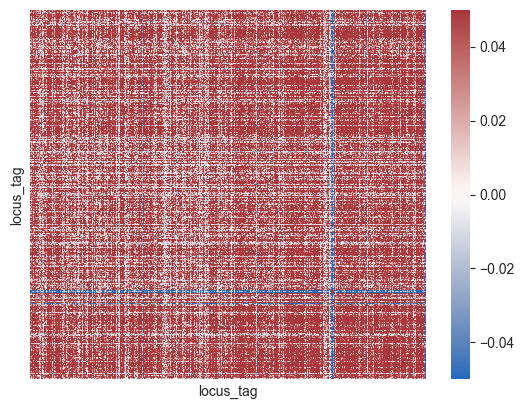

In [22]:
sns.heatmap(cor_vst.loc[gff.index, gff.index],
            cmap='vlag', vmin=-1, vmax=1, center=0,
            xticklabels=False, yticklabels=False)
plt.show()
sns.heatmap(cor_vst.loc[gff.index, gff.index],
            cmap='vlag', vmin=-0.05, vmax=0.05, center=0,
            xticklabels=False, yticklabels=False)
plt.show()

## With normalized and scaled data

In [23]:
data_gene.X = data_gene.layers["vst_counts"].copy()
sc.pp.scale(data_gene, max_value=10, zero_center=True)
data_gene.layers["scaled_counts"] = data_gene.X.copy()

In [24]:
cor_scale = spearmanr(data_gene.X)
cor_scale = pd.DataFrame(cor_scale.statistic, index=data_gene.var_names, columns=data_gene.var_names)

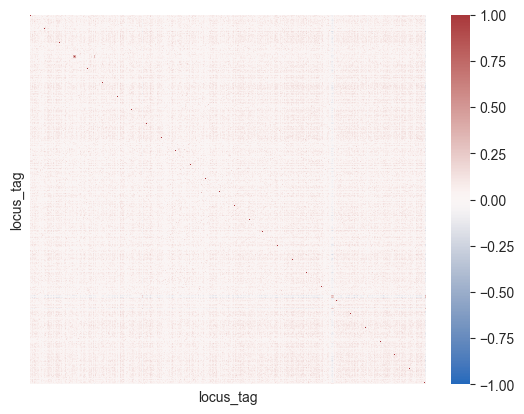

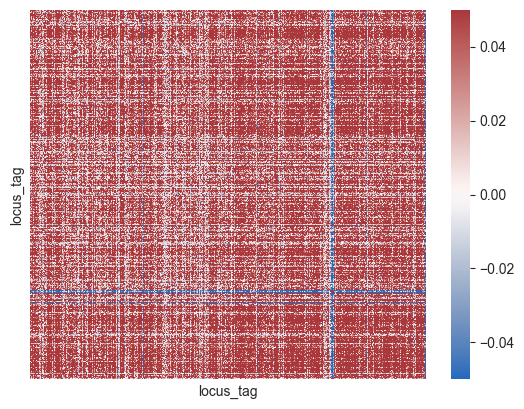

In [25]:
sns.heatmap(cor_scale.loc[gff.index, gff.index],
            cmap='vlag', vmin=-1, vmax=1, center=0,
            xticklabels=False, yticklabels=False)
plt.show()
sns.heatmap(cor_scale.loc[gff.index, gff.index],
            cmap='vlag', vmin=-0.05, vmax=0.05, center=0,
            xticklabels=False, yticklabels=False)
plt.show()

In [43]:
print(cor_scale.sum(axis=0).sort_values().head(10))


PAO1_ID
PA4264   -393.297636
PA4256   -376.113075
PA4268   -375.598531
PA4241   -373.043594
PA4262   -372.101169
PA4260   -370.509008
PA4267   -364.694375
PA4252   -364.061038
PA4259   -363.243171
PA4258   -362.550056
dtype: float64


## With binned expression

In [26]:
from collections import OrderedDict

def create_bins(gff, chrom_length, bin_size):
    bins = OrderedDict()
    if type(bin_size) is float:
        bin_size = int(bin_size)
    for bin_start in range(1, chrom_length + 1, bin_size):
        bin_end = bin_start + bin_size - 1
        if bin_end > chrom_length:
            bin_end = chrom_length
        bins[(bin_start, bin_end)] = list(gff.loc[(bin_start <= gff['coord']) & (gff['coord'] <= bin_end), 'locus_tag'])
    return bins

### Function to create binned expression
# This takes the bin dictionary and averages gene expression within each bin.
def bin_expression(counts, bins):
    bin_names = []
    binned_expression = []
    for bin in bins:
        bin_names.append((bin[0] + bin[1]) / 2)
        binned_expression.append(counts.loc[:,np.isin(counts.columns, bins[bin])].mean(axis=1))
    binned_expression_df = pd.DataFrame(binned_expression).transpose()
    binned_expression_df.columns = bin_names
    return binned_expression_df

In [27]:
bins = create_bins(gff, chrom_length, 50000)

In [28]:
scaled_expression = pd.DataFrame(data_gene.layers["scaled_counts"].copy(), index=data_gene.obs_names, columns=data_gene.var_names)
binned_expression = bin_expression(scaled_expression, bins)
binned_expression.iloc[:10, :10]

,25000.5,75000.5,125000.5,175000.5,225000.5,275000.5,325000.5,375000.5,425000.5,475000.5
AAACCCAGTGGACCTC-1,-0.273557,-0.014401,0.105554,-0.179420,0.009093,-0.068308,-0.104709,0.016019,0.114655,0.151078
AAACCCATCCTGTAGA-1,-0.125959,-0.157685,-0.021557,0.172641,-0.140347,-0.190592,-0.244332,-0.000845,-0.206305,-0.173164
AAACGCTCAGATTTCG-1,0.332073,-0.284307,-0.269814,0.172037,-0.190874,-0.190592,-0.114458,-0.076472,-0.099517,0.085190
AAACGCTTCTTTGCTA-1,0.065571,-0.284307,-0.098883,-0.158453,-0.190874,0.006856,-0.049132,0.059551,-0.052789,-0.093983
AAAGAACCAGTCTGGC-1,-0.092823,-0.028894,-0.243960,0.207761,-0.140787,0.008678,-0.116010,0.180078,0.077865,0.154400
AAAGAACGTTTCAGAC-1,-0.154562,0.110832,-0.238164,-0.060435,-0.190874,-0.023902,-0.093265,-0.009741,-0.031860,-0.084119
AAAGAACTCTGTCCCA-1,-0.097262,-0.225554,0.021503,-0.015934,-0.104851,-0.190592,-0.230105,-0.165868,-0.229568,-0.322990
AAAGGATAGTCACAGG-1,-0.130427,-0.067314,0.032549,0.013555,0.148464,-0.190592,0.033386,0.010347,-0.132464,-0.116809
AAAGGATCATCGAACT-1,-0.309184,-0.060152,-0.209441,-0.084138,0.211936,-0.190592,-0.084555,-0.227001,-0.111611,-0.137139
AAAGGATGTGAATGAT-1,0.058485,-0.222359,-0.057470,0.023287,0.318741,-0.089589,-0.067483,0.027785,0.070081,-0.163149


In [29]:
cor_bin = spearmanr(binned_expression).statistic

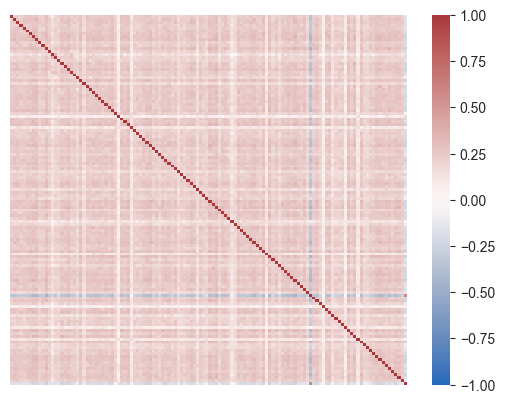

In [30]:
sns.heatmap(cor_bin, center=0, vmin=-1, vmax=1, cmap='vlag', xticklabels=False, yticklabels=False)
plt.show()

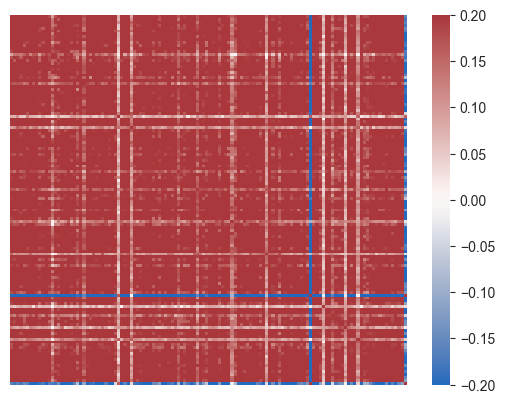

In [31]:
sns.heatmap(cor_bin, center=0, vmin=-0.2, vmax=0.2, cmap='vlag', xticklabels=False, yticklabels=False)
plt.show()